# Spectrum Re-Calibration

Recalibrating the spectra taken at Palomar against the standard star... let's see if this works. Started 20 November 2019.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import integrate
import emcee
import corner
from fu_ori_functions_new import *
from fu_ori_classes_new import *
%matplotlib inline 

In [2]:
G = 6.67259e-8
SIG_SB = 5.67051e-5
M_SUN = 1.99e33
R_SUN = 6.96e10
L_SUN = 3.839e33
h_PLANCK = 6.6260755e-27
c_LIGHT = 2.99792458e10
k_BOLTZ = 1.380658e-16

## Reading in Palomar data

In [3]:
def cleanPoints(waves, lums, regions):
    waves_final, lums_final = [], []
    exclude = []
    for i in range(len(regions)):
        start, end = regions[i]
        ind_lower = np.searchsorted(waves, int(start))
        ind_upper = np.searchsorted(waves, end)
        bad_points = np.arange(ind_lower, ind_upper+1, 1)
        for i in range(len(bad_points)):
            exclude.append(bad_points[i])

    waves_final = np.delete(waves, exclude)
    lums_final = np.delete(lums, exclude)
    return waves_final, lums_final

In [4]:
PATH = 'C:/Users/tonyc/OneDrive/Documents/2019 Summer/Data/BD25 3941/'
PATH2 = 'C:/Users/tonyc/OneDrive/Documents/2019 Summer/Data/Gaia 17bpi/'

In [5]:
def getDataArray(data_file):
    txt = open(data_file)
    fulltxt = txt.readlines()
    # Cleaning lines
    newtxt = []
    for i in range(len(fulltxt)):
        line = fulltxt[i][:-1]
        line = line.split()
        if line[0] == '#':
            line = [line[1], line[2]]
        newtxt.append(line)
    # Casting as floats
    newtxt = np.array(newtxt).astype(np.float64)
    return newtxt

In [6]:
def getDataArrayMod(data_file):
    txt = open(data_file)
    fulltxt = txt.readlines()
    # Cleaning lines
    newtxt = []
    for i in range(1,len(fulltxt)):
        line = fulltxt[i][:-1]
        line = line.split()
        if line[0] == '#':
            line = [line[1], line[2]]
        newtxt.append(line)
    # Casting as floats
    newtxt = np.array(newtxt).astype(np.float64)
    return newtxt

In [22]:
newtxt = getDataArray(PATH + 'blue0101.spec.txt')

wavesDATA_OPT = newtxt[:,0] 
fluxesDATA_OPT = newtxt[:,1]

newtxt2 = getDataArray(PATH + 'bd253941.dat')
wavesDATA_OPT_STD = newtxt2[:,0] 
fluxesDATA_OPT_STD = newtxt2[:,1]
col3 = newtxt2[:,2]

newtxt3 = getDataArray(PATH2 + 'blue0102.spec.txt')
waves_GAIA_CTS = newtxt3[:,0] 
fluxes_GAIA_CTS = newtxt3[:,1]

newtxt4 = getDataArray(PATH2 + 'blue0102_flux.spec.txt')
waves_GAIA_FLUX = newtxt4[:,0] 
fluxes_GAIA_FLUX = newtxt4[:,1]

newtxt5 = getDataArrayMod(PATH + 'std-blue')
waves_PHOT_STD = newtxt5[:,0] 
fluxes_PHOT_STD = newtxt5[:,1]
unknown_PHOT_STD = newtxt5[:,3]

newtxt6 = getDataArray(PATH + 'calib_txt')

waves_NORM = newtxt6[:,0] 
fluxes_NORM = newtxt6[:,1]




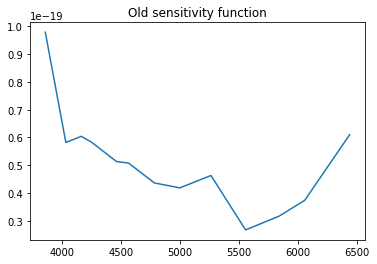

In [23]:
plt.plot(waves_PHOT_STD, fluxes_PHOT_STD/unknown_PHOT_STD)
plt.title('Old sensitivity function')
plt.show()

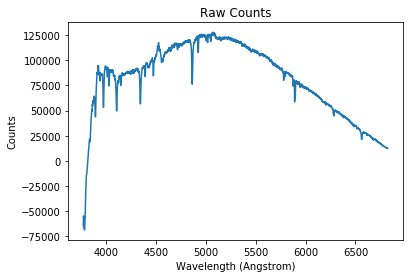

In [24]:
plt.plot(wavesDATA_OPT, fluxesDATA_OPT)
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Counts')
plt.title('Raw Counts')
plt.show()

### Converting to $F_\lambda$

In [25]:
F_NU = 10**(-(fluxesDATA_OPT_STD + 48.585)/2.5)

In [26]:
F_LAMBDA = F_NU*c_LIGHT/((wavesDATA_OPT_STD*1e-8)**2)

Picking out best range

In [27]:
waves_STD = wavesDATA_OPT_STD[11:58]
fluxes_STD = F_LAMBDA[11:58]*1e-8

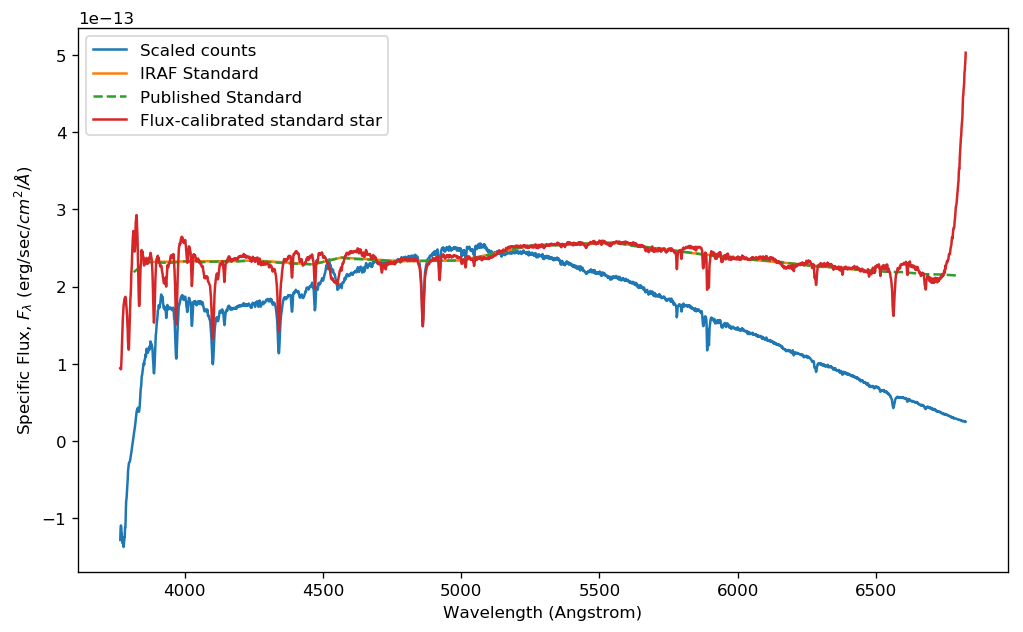

In [33]:
fig = plt.figure(figsize=(10,6), dpi=120)

plt.plot(wavesDATA_OPT, 2e-18*fluxesDATA_OPT, label='Scaled counts')
plt.plot(waves_PHOT_STD, fluxes_PHOT_STD, label='IRAF Standard')
plt.plot(waves_STD, fluxes_STD, '--', label='Published Standard')
plt.plot(waves_NORM, fluxes_NORM, label='Flux-calibrated standard star')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel(r'Specific Flux, $F_\lambda$ (erg/sec/$cm^2$/$\AA$)')
plt.legend()
plt.show()

In [15]:
import spectres

Interpolating the raw counts to the grid of standard wavelengths:

In [60]:
NEW_COUNTS = spectres.spectres(waves_STD, wavesDATA_OPT,\
                             fluxesDATA_OPT)

In [61]:
FACTOR = fluxes_STD/NEW_COUNTS

(0, 1e-19)

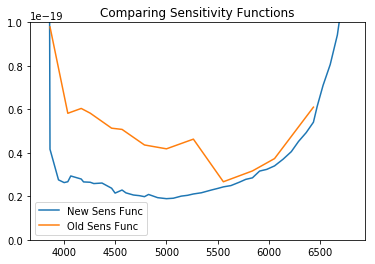

In [71]:
plt.plot(waves_STD, (1/100)*FACTOR, label='New Sens Func')
plt.plot(waves_PHOT_STD, fluxes_PHOT_STD/unknown_PHOT_STD, label='Old Sens Func')
plt.plot()
plt.legend()
plt.title('Comparing Sensitivity Functions')
plt.ylim(0, 1e-19)

In [29]:
func = interpolate.interp1d(waves_STD, FACTOR)

In [22]:
min(waves_STD), max(waves_STD)

(3816.0, 6790.0)

In [23]:
waves_GAIA_CTS = waves_GAIA_CTS[50:-50]

In [24]:
fluxes_GAIA_CTS = fluxes_GAIA_CTS[50:-50]
waves_GAIA_FLUX = waves_GAIA_FLUX[50:-50]
fluxes_GAIA_FLUX = fluxes_GAIA_FLUX[50:-50]

In [25]:
min(waves_GAIA_CTS), max(waves_GAIA_CTS)

(3821.5190768665, 6770.1436506416)

In [30]:
scale = func(waves_GAIA_FLUX)


In [31]:
fluxes_GAIA_FIXED = (1/12)*scale*fluxes_GAIA_CTS

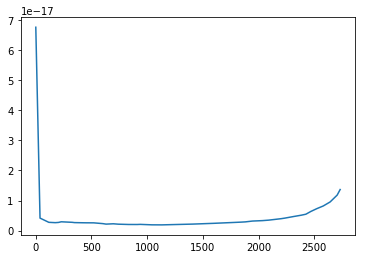

In [33]:
plt.plot(scale)

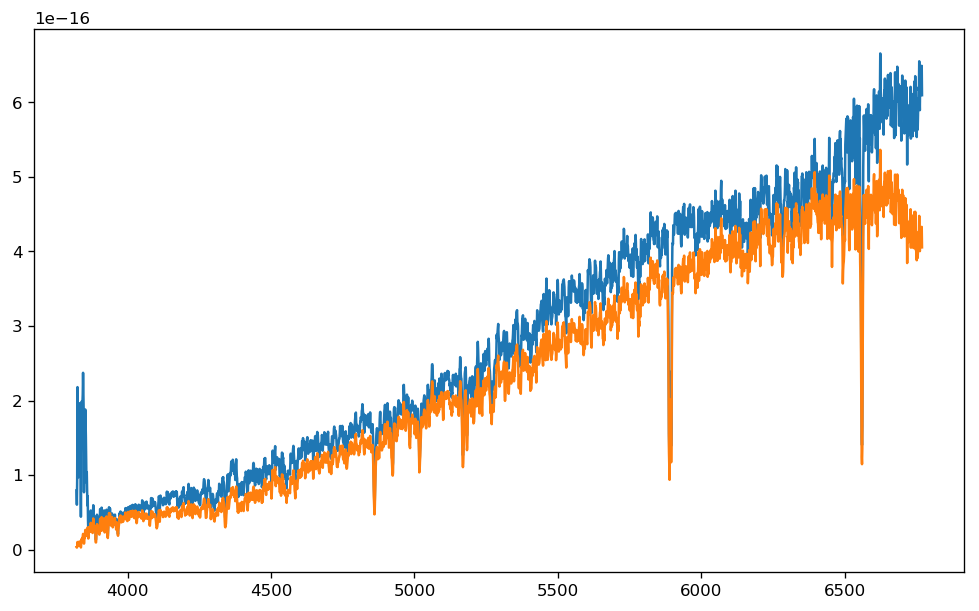

In [91]:
fig = plt.figure(figsize=(10,6), dpi=120)

plt.plot(waves_GAIA_CTS, (1/12)*scale*fluxes_GAIA_CTS)
plt.plot(waves_GAIA_FLUX, fluxes_GAIA_FLUX)
# plt.plot(waves_GAIA_CTS, 1e-20*scale_new*fluxes_GAIA_CTS)
# plt.plot(waves_GAIA_CTS, 2.8e-19*fluxes_GAIA_CTS)

In [74]:
import csv
with open('bd253941_new', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=' ')
    writer.writerows(zip(waves_STD, fluxes_STD, np.ones(len(fluxes_STD))*98, fluxes_STD*1e2/FACTOR))